# 7 Hands-on

## 7.1 Introduction
Well-log data from five wells are provided in flat ascii text files.  Well 2 is taken as the type-well.  Six different lithofacies have been identified from Well 2.  For the purposes of the problem sets and the project the facies are: xxxxx.  The depth zones containing data for these facies have been extracted from Well 2 and provided in separate text files.  The seismic data consist of one 2D section of NMO-corrected pre-stack CDP gathers, and two 3D cubes of near- and far-offset partial stacks.  Details about the seismic data and well locations within the seismic cubes are provided below in Section 7.3

## 7.2 Problems
### Rock physics modeling
Load the well-log data for Well 2.  The ascii file contains five columns: depth, Vp, density, gamma ray and Vs

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
from packages.functions import * # vrh, softsand, stiffsand, hertzmindlin, vels, rpt

In [3]:
# Parameters and rock properties
TEMP_RES = 70  #Celcius                                # or 77.2
PRESSURE_EFF = 16  #MPa                                # or 20
# PRESSURE_EFF = (den - den_fluid)*g x depth  # g=9.8

SALINITY = 80000  #PPM

# Fluid properties
RHO_BRINE = 1.09 # g/cm3
K_BRINE = 2.8  #GPa
RHO_OIL = 0.78  #g/cm3
K_OIL = 2.
OIL_GRAVITY = 19  #API                                # or 32
GOR = 100  #Sm3/Sm3                                   # or 64
GAS_GRAVITY = 0.6

# Rock properties
K_QUARTZ = 36.8  #GPa
MU_QUARTZ = 44  #GPa
K_CLAY = 15  #GPa
MU_CLAY = 5  #GPa

# calculate fluid bulk modulus of oil before pore-fluid substitution => use Batzle-Wang
# caluculate mineral moduli 

## Glossary of abbreviations

### Bulk modulus

$K_{rock}$: saturated rock (e.g. mixture of quartz, clay matrix and brine, gas fluid)

$K_{sat}$: saturated rock (as above)

$K_{mineral}$: mineral (e.g. K(quartz)=36, K(clay)=44, K(brine)=2.4

$K_{min}$: as above -> abbreviation

$K_{\phi}$: pore space stiffness ($\approx \alpha K_{mineral}$, where $\alpha$ is aspect ratio)

$K_{fluid}$: pore filling fluid

$K_{br}$:
$K_{oil}$:
$K_{gas}$:

$\tilde{K}_{\phi}$: saturated pore space ($= K_{\phi} + K_{fluid}$)

$K_{dry}$: dry rock

$\frac{K}{K_{min}}$: where $K$ is $K_{sat}$ or $K_{dry}$


In [4]:
# well1 = pd.read_csv("./data/well_1.txt", header=None, skiprows=1, sep="  ", usecols=[0,4,8,11])
# well1.rename(columns={0:"DEPTH", 4:"VP", 8:"DEN", 11:"GR"}, inplace=True)

well2 = pd.read_csv("./data/well_2.txt", header=None, skiprows=1, sep="  ", usecols=[0,3,6,9,11,14])
well2.rename(columns={0:"DEPTH", 3:"VP", 6:"VS", 9:"DEN", 11:"GR", 14:"NPHI" }, inplace=True)

# well3 = pd.read_csv("./data/well_3.txt", header=None, skiprows=1, sep=" ", usecols=[5,13,17,24])
# well3.rename(columns={5:"DEPTH", 13:"VP", 17:"DEN", 24:"GR"}, inplace=True)

# well4 = pd.read_csv("./data/well_4.txt", header=None, skiprows=1, sep=" ", usecols=[4,12,20,27])
# well4.rename(columns={4:"DEPTH", 12:"VP", 20:"DEN", 27:"GR"}, inplace=True)

# well5 = pd.read_csv("./data/well_5.txt", header=None, skiprows=1, sep=" ", usecols=[3,6,9,12,15])
# well5.rename(columns={3:"DEPTH", 6:"t_p", 9:"t_s", 12:"GR", 15:"DEN"}, inplace=True)

In [5]:
import platform
my_os = platform.system()
print("OS in my system : ",my_os)

if my_os == 'Windows':
    path = r"C:\Users\Dunbar\Dropbox\Work\QSI\data"
elif my_os == 'Linux':
    path = '/home/alex/Dropbox/Work/QSI/data'
    
print(f"file path: {path}")

OS in my system :  Windows
file path: C:\Users\Dunbar\Dropbox\Work\QSI\data


In [6]:
file = 'well_3.las'

path_file = path + "\\" + file

# path = r'C:\Users\ALDUNBAR\OneDrive - Wintershall Dea AG\Python\data'
# file = 'well-3.las'

#!pip install lasio
import lasio

well = lasio.read(path_file)

well3 = well.df()

well3 = well3.replace(-9999.0,np.NaN)
well3 = well3[(well3.index>2100)&(well3.index<2300)]
well3.reset_index(inplace=True)
well3.rename(columns = {'DEPT':'DEPTH'}, inplace = True)

In [7]:
def vshale_from_gr(df):
    """
    Creates Clavier, Larionov old, Larionov new, Steiber VSH
    """    
    GR_min = df.GR.min()
    GR_max = df.GR.max()
    df.loc[:, 'IGR'] = (df.GR - GR_min) / (GR_max - GR_min)
    df.loc[:, 'VSH_clavier'] = 1.7 - ((3.38 - (df.IGR + 0.7)**2)**0.5)
    df.loc[:, 'VSH_larionovO'] = 0.33 * (2**(2*df.IGR)-1)
    df.loc[:, 'VSH_steiber'] = df.IGR / (3 - 2*df.IGR)
    df.loc[:, 'VSH_larionovT'] = 0.083*(2**(3.7*df.IGR)-1)
    # Pick one to be "main" VSH
    df['VSH'] = df.VSH_larionovO
    return df

In [8]:
well2 = vshale_from_gr(well2)

well2["PHIE"] = (2.65- well2.DEN)/(2.65 - 1.05)
# well2["VSH"] = (well2.GR - well2.GR.min()) / (well2.GR.max()-well2.GR.min())
well2["IP"] = well2.VP*1000 * well2.DEN
well2["IS"] = well2.VS*1000 * well2.DEN
well2["VPVS"] = well2.VP / well2.VS
well2['K'] = well2.DEN*(well2.VP**2 - 4/3.*(well2.VS)**2)  # ?? what is this bulk modulus ??

well2['sandy-shaly'] = np.where(well2['VSH'] >= 0.35, 'shaly', 'sandy')

In [9]:
# 
shale = well2.VSH.values  # 

sand = 1 - shale - well2.PHIE.values
shaleN = shale / (shale+sand)  # normalized shale and sand volumes
sandN  = sand / (shale+sand)

# mineral mixture bulk and shear moduli, k0 and mu0  # ?? A mineral mixture BUT NOT dry rock bulk modulus??
k_u, k_l, mu_u, mu_l, k0, mu0 = vrh([shaleN, sandN], [K_CLAY, K_QUARTZ], [MU_CLAY, MU_QUARTZ])

well2['K0'] = k0

In [10]:
facies = [6, 0, 6, 1, 2, 6, 3, 6, 4, 6, 5, 6]

conditions = [
    (well2["DEPTH"].ge(well2.DEPTH.min()) & well2["DEPTH"].lt(2078.0)), # undef=0    6
    (well2["DEPTH"].ge(2078.0) & well2["DEPTH"].lt(2105.0)),            # shale=1    0
    (well2["DEPTH"].ge(2105.0) & well2["DEPTH"].lt(2143.2)),            # undef=0    6
    (well2["DEPTH"].ge(2143.2) & well2["DEPTH"].lt(2154.1)),            # sltShale=2 1
    (well2["DEPTH"].ge(2154.1) & well2["DEPTH"].lt(2164.1)),            # clnSand=3  2 
    (well2["DEPTH"].ge(2164.1) & well2["DEPTH"].lt(2168.1)),            # undef=0    6
    (well2["DEPTH"].ge(2168.1) & well2["DEPTH"].lt(2184.1)),            # sltSand1=4 3  
    (well2["DEPTH"].ge(2184.1) & well2["DEPTH"].lt(2186.1)),            # undef=0    6
    (well2["DEPTH"].ge(2186.1) & well2["DEPTH"].lt(2200.1)),            # sltSand2=5 4  
    (well2["DEPTH"].ge(2200.1) & well2["DEPTH"].lt(2254.0)),            # undef=0    6
    (well2["DEPTH"].ge(2254.0) & well2["DEPTH"].lt(2300.1)),            # cemSand=6  5
    (well2["DEPTH"].ge(2300.1) & well2["DEPTH"].lt(well2.DEPTH.max()))  # undef=0    6
]

well2["FCODES"] = np.select(conditions, facies)

In [11]:
facies = [1,2,3,4,5,6]

conditions = [
    (well2["DEPTH"].ge(2078.0) & well2["DEPTH"].lt(2105.0)),
    (well2["DEPTH"].ge(2143.2) & well2["DEPTH"].lt(2154.1)),
    (well2["DEPTH"].ge(2154.1) & well2["DEPTH"].lt(2164.1)),
    (well2["DEPTH"].ge(2168.1) & well2["DEPTH"].lt(2184.1)),
    (well2["DEPTH"].ge(2186.1) & well2["DEPTH"].lt(2200.1)),
    (well2["DEPTH"].ge(2254.0) & well2["DEPTH"].lt(2300.1)),
]

well2["FACIES"] = np.select(conditions, facies)

In [12]:
facies_labels = ["shale", "sltShale", "clnSand", "sltSand1", "sltSand2", "cemSand"]

conditions = [
    (well2["DEPTH"].ge(2078.0) & well2["DEPTH"].lt(2105.0)),
    (well2["DEPTH"].ge(2143.2) & well2["DEPTH"].lt(2154.1)),
    (well2["DEPTH"].ge(2154.1) & well2["DEPTH"].lt(2164.1)),
    (well2["DEPTH"].ge(2168.1) & well2["DEPTH"].lt(2184.1)),
    (well2["DEPTH"].ge(2186.1) & well2["DEPTH"].lt(2200.1)),
    (well2["DEPTH"].ge(2254.0) & well2["DEPTH"].lt(2300.1)),
]

well2["LABELS"] = np.select(conditions, facies_labels)

In [13]:
reservoir = [0, 0, 1, 1, 0, 1]
conditions = [
    (well2["DEPTH"].ge(2078.0) & well2["DEPTH"].lt(2105.0)),
    (well2["DEPTH"].ge(2143.2) & well2["DEPTH"].lt(2154.1)),
    (well2["DEPTH"].ge(2154.1) & well2["DEPTH"].lt(2164.1)),
    (well2["DEPTH"].ge(2168.1) & well2["DEPTH"].lt(2184.1)),
    (well2["DEPTH"].ge(2186.1) & well2["DEPTH"].lt(2200.1)),
    (well2["DEPTH"].ge(2254.0) & well2["DEPTH"].lt(2300.1)),
]

well2["RESERVOIR"] = np.select(conditions, reservoir)

In [14]:
well2[well2.LABELS!='0'].head()

,DEPTH,VP,VS,DEN,GR,NPHI,IGR,VSH_clavier,VSH_larionovO,VSH_steiber,VSH_larionovT,VSH,PHIE,IP,IS,VPVS,K,sandy-shaly,K0,FCODES,FACIES,LABELS,RESERVOIR
425,2078.0227,2.3718,1.0085,2.2488,93.0723,0.4134,0.507165,0.313366,0.336588,0.255413,0.221764,0.336588,0.250750,5333.70384,2267.91480,2.351810,9.600889,sandy,24.635396,0,1,shale,0
426,2078.1753,2.3451,0.9570,2.2402,96.5476,0.4280,0.546592,0.348702,0.374037,0.286652,0.254193,0.374037,0.256125,5253.49302,2143.87140,2.450470,9.584387,shaly,23.550356,0,1,shale,0
427,2078.3276,2.2836,0.9144,2.2260,99.9090,0.4129,0.584728,0.384905,0.412258,0.319428,0.288838,0.412258,0.265000,5083.29360,2035.45440,2.497375,9.126583,shaly,22.423036,0,1,shale,0
428,2078.4800,2.2928,0.9144,2.2287,106.7446,0.4309,0.662278,0.465416,0.496504,0.395285,0.370660,0.496504,0.263313,5109.96336,2037.92328,2.507437,9.231488,shaly,20.349016,0,1,shale,0
429,2078.6323,2.2979,0.9494,2.2316,106.3187,0.4332,0.657446,0.460105,0.490986,0.390151,0.365073,0.490986,0.261500,5127.99364,2118.68104,2.420371,9.101649,shaly,20.511184,0,1,shale,0


In [15]:
well2.DEPTH.min(), well2.DEPTH.max()

(2013.2528, 2640.5312)

In [16]:
import matplotlib.colors as colors
#      "shale",  "sltShale", "clnSand", "sltSand1", "sltSand2", "cemSand", "undef"
ccc = ['#996633', '#1B4F72', '#FFC82E','#FF7A36', '#DB0000', '#40CBFF', '#B3B3B3']
cmap_facies = colors.ListedColormap(ccc[0:len(ccc)], 'indexed')

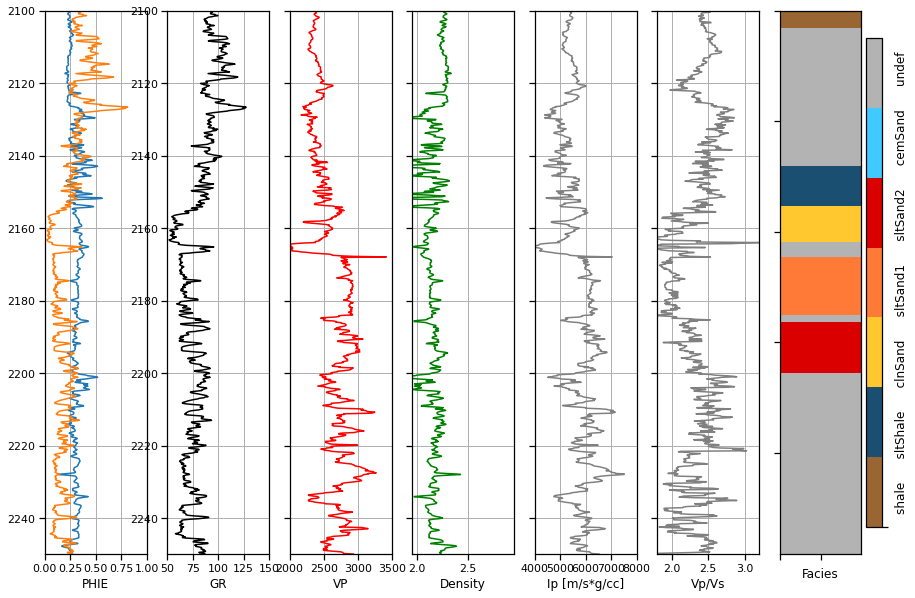

In [17]:
ztop=2100; zbot=2250
ll=well2[(well2.DEPTH>=ztop) & (well2.DEPTH<=zbot)]

cluster=np.repeat(np.expand_dims(ll['FCODES'].values,1), 100, 1)

f, ax = plt.subplots(nrows=1, ncols=7, figsize=(15, 10))

ax[0].plot(ll.PHIE,    ll.DEPTH, label='PHIE')
ax[0].plot(ll.VSH,     ll.DEPTH, label='VSH')
ax[1].plot(ll.GR,      ll.DEPTH, '-k', label='GR')
ax[2].plot(ll.VP*1000, ll.DEPTH, '-r', label='VP')
ax[3].plot(ll.DEN,     ll.DEPTH, '-g', label='Density')
ax[4].plot(ll.IP,      ll.DEPTH, '-', color='0.5')
ax[5].plot(ll.VPVS,    ll.DEPTH, '-', color='0.5')
im=ax[6].imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=len(ax)-1)#4)

cbar=plt.colorbar(im, ax=ax[6], aspect=32)
#cbar.set_label('0=undef,1=shale,2=sltShale,3=clnSand,4=sltSand1,5=sltSand2,6=cemSand')
# cbar.set_ticks(range(0,4+1)); cbar.set_ticklabels(range(0,4+1))
cbar.set_label((6*' ').join(['shale', 'sltShale', 'clnSand', 'sltSand1', 'sltSand2', 'cemSand', 'undef']))

cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

for i in range(len(ax)-1):
    ax[i].set_ylim(ztop,zbot)
    ax[i].invert_yaxis()
    ax[i].grid()
    ax[i].locator_params(axis='x', nbins=4)
#ax[0].legend(fontsize='small', loc='lower right')

ax[0].set_xlabel("PHIE"),          ax[0].set_xlim(0,1)
ax[1].set_xlabel("GR"),            ax[1].set_xlim(50, 150),     #ax[1].set_yticklabels([])
ax[2].set_xlabel("VP"),            ax[2].set_xlim(2000, 3500), ax[2].set_yticklabels([])
ax[3].set_xlabel("Density"),       ax[3].set_xlim(1.95, 2.95), ax[3].set_yticklabels([])
ax[4].set_xlabel("Ip [m/s*g/cc]"), ax[4].set_xlim(4000,8000), ax[4].set_yticklabels([])
ax[5].set_xlabel("Vp/Vs"),         ax[5].set_xlim(1.8,3.2),    ax[5].set_yticklabels([])
ax[6].set_xlabel('Facies'),        ax[6].set_yticklabels([]),  ax[6].set_xticklabels([]);

# for i in range(len(ax)-1):
#     for top in tops.values() :
#         f.axes[i].axhline( y = float(top), color = 'b', lw = 2, 
#                             ls = ':',  
#                             alpha = 0.5, xmin = 0.05, xmax = 0.95 )
# for top, depth in tops.items():
#     if (ztop < depth < zbot):
#         ax[0].text( x = max(ax[0].xaxis.get_data_interval())*1.0,
#                   y = float(depth), s = top,
#                              alpha=0.75, color='k',
#                              fontsize = '10',
#                              horizontalalignment = 'left',
#                              verticalalignment = 'center',
#                              bbox=dict(facecolor='white', alpha=1.0, lw = 0.25),
#                              weight = 'light')



#plt.savefig("./images/logs_basic.png")

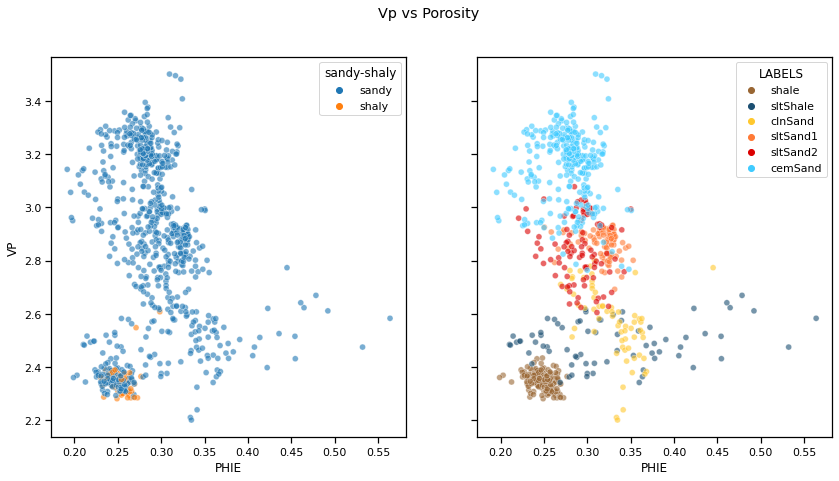

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14,7))
fig.suptitle('Vp vs Porosity')
sns.scatterplot(ax=ax1, data=well2[well2.LABELS!='0'], x="PHIE", y="VP", hue='sandy-shaly', alpha=0.6)
sns.scatterplot(ax=ax2, data=well2[well2.LABELS!='0'], x="PHIE", y="VP", hue='LABELS', palette=ccc[:-1], alpha=0.6)
plt.show();

## Rock physics modeling

## 1.

Make cross-plots of Vp versus porosity.

### Q: What can you say about the trends of shales versus sands?
 
Sandier sections tend to decrease in porosity with an increase in p-wave velocity.  `clnSand` has the highest porosity and lowest p-wave velocity.  `sltSand1` has slightly higher porosit than `sltSand2` with similar p-wave velocities. `cemSand` has the lowest porosity and highest p-wave velocity.

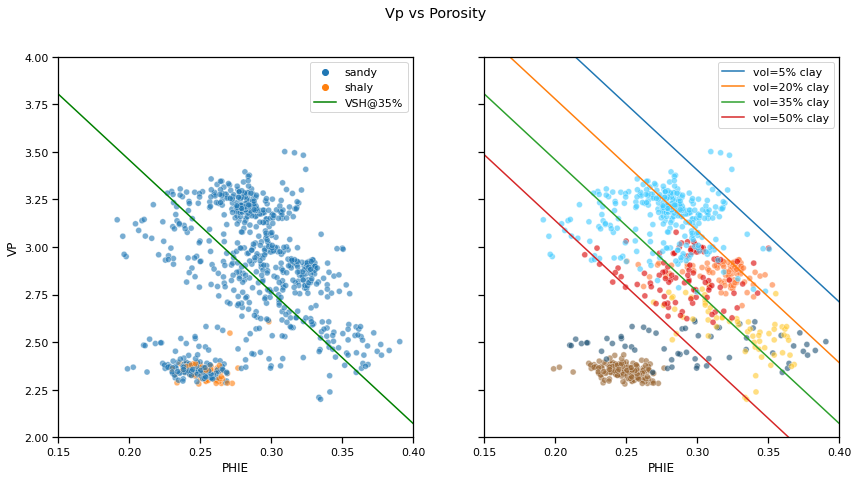

In [19]:
### SANDY - SHALY colours have switched around. sandy-orange, shaly-blue

# Han's empirical relations
phi = np.linspace(0, 1, 1000)
vclay = [0.05, 0.20, 0.35, 0.5]

hans_vp05, hans_vp20, hans_vp35, hans_vp50 = [],[],[],[]
 
for i in range(len(phi)):
    hans_vp05.append((5.59 - 2.13*vclay[0])-6.93*phi[i])
    hans_vp20.append((5.59 - 2.13*vclay[1])-6.93*phi[i])
    hans_vp35.append((5.59 - 2.13*vclay[2])-6.93*phi[i])
    hans_vp50.append((5.59 - 2.13*vclay[3])-6.93*phi[i])

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14,7))
fig.suptitle('Vp vs Porosity')
sns.scatterplot(ax=ax1, data=well2[well2.LABELS!='0'], x="PHIE", y="VP", hue='sandy-shaly', alpha=0.6)
ax2.plot(phi, hans_vp05, label="vol=5% clay")
ax2.plot(phi, hans_vp20, label="vol=20% clay")
ax2.plot(phi, hans_vp35, label="vol=35% clay")
ax2.plot(phi, hans_vp50, label="vol=50% clay")
ax2.legend()
sns.scatterplot(ax=ax2, data=well2[well2.LABELS!='0'], x="PHIE", y="VP", hue='LABELS', legend=False, palette=ccc[:-1], alpha=0.6)
ax1.plot(phi, hans_vp35, '-g', label="VSH@35%")
ax1.legend()
plt.xlim(0.15, 0.4)
plt.ylim(2, 4)
plt.show();

### Q: How do you explain porosity variation for each lithology class?
 
* `shale`: very little variation - homogenous?
* `sltShale`: largest variation - heterogeneous?
* `clnSand`: little porosity variation
* `sltSand1`: little porosity variation
* `sltSand2`: little porosity variation
* `cemSand`: majority of samples with low variation, has some outliers

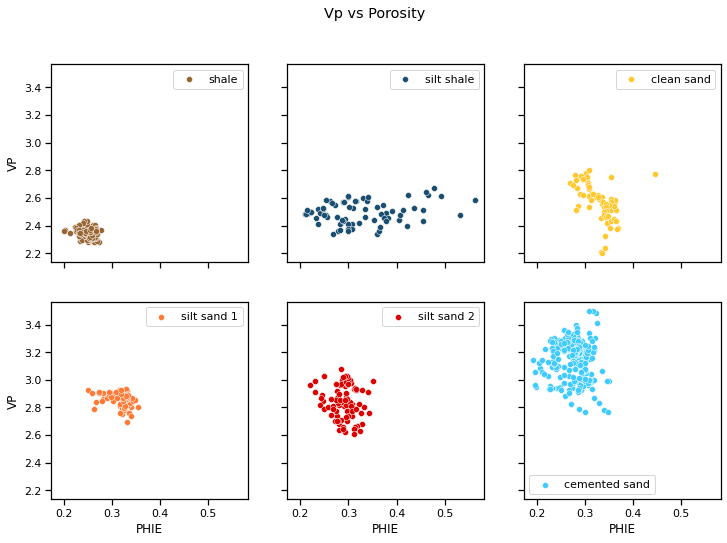

In [20]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,8))
fig.suptitle('Vp vs Porosity')
sns.scatterplot(ax=ax1, x=well2[well2.LABELS=='shale']['PHIE'], y=well2[well2.LABELS=='shale']['VP'], color=ccc[0], label="shale")
sns.scatterplot(ax=ax2, x=well2[well2.LABELS=='sltShale']['PHIE'], y=well2[well2.LABELS=='sltShale']['VP'], color=ccc[1], label="silt shale")
sns.scatterplot(ax=ax3, x=well2[well2.LABELS=='clnSand']['PHIE'], y=well2[well2.LABELS=='clnSand']['VP'], color=ccc[2], label="clean sand")
sns.scatterplot(ax=ax4, x=well2[well2.LABELS=='sltSand1']['PHIE'], y=well2[well2.LABELS=='sltSand1']['VP'], color=ccc[3], label="silt sand 1")
sns.scatterplot(ax=ax5, x=well2[well2.LABELS=='sltSand2']['PHIE'], y=well2[well2.LABELS=='sltSand2']['VP'], color=ccc[4], label="silt sand 2")
sns.scatterplot(ax=ax6, x=well2[well2.LABELS=='cemSand']['PHIE'], y=well2[well2.LABELS=='cemSand']['VP'], color=ccc[5], label="cemented sand")

for ax in fig.get_axes():
    ax.label_outer()

Compare with upper and lower Hashin-Shtrikman bounds.

Compare with Han's empirical sandstone line, assuming 5% clay content.

### Q: Is there a good match?  If not, how do you explain the mismatch?
Answer: 

---

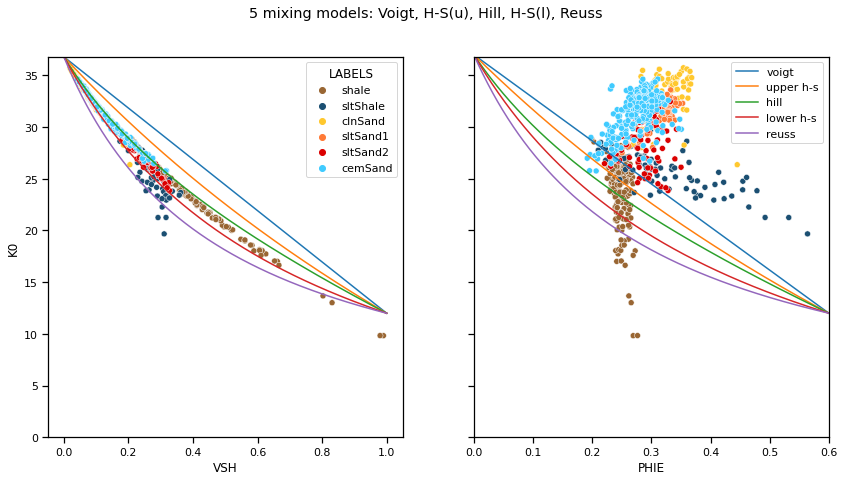

In [21]:
f1 = np.linspace(0, 1, 1000)
f2 = 1-f1

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,  figsize=(14,7))  # sharex=True, sharey=True,
fig.suptitle('5 mixing models: Voigt, H-S(u), Hill, H-S(l), Reuss')

k2 = K_QUARTZ # = 37
k1 = 12  # K_CLAY # = 15
mu2 = MU_QUARTZ # = 44
mu1 = MU_CLAY # = 5
xs = np.linspace(0,1,1000)
#xs = np.linspace(0,0.4,1000)
hs_upper, hs_lower = [],[]
reuss, voigt, hill = [],[],[]

for i in range(len(f1)):
    hs_upper.append(k2 + f1[i]/( (1/(k1-k2)) + f2[i]/(k2+(4/3.*mu2))))
    hs_lower.append(k1 + f2[i]/( (1/(k2-k1)) + f1[i]/(k1+(4/3.*mu1))))
    reuss_i = 1/( (f2[i]/k2) + f1[i]/k1 )
    reuss.append(reuss_i)
    voigt_i = f2[i]*k2 + f1[i]*k1
    voigt.append(voigt_i)
    hill.append((reuss_i + voigt_i)/2.)
    

#sns.scatterplot(ax=ax1, data=well2[well2.LABELS != '0'], x='PHIE', y='K', hue='LABELS', palette=ccc[:-1])
sns.scatterplot(ax=ax1, data=well2[well2.LABELS != '0'], x='VSH', y='K0', hue='LABELS', palette=ccc[:-1])
ax1.plot(xs, voigt, label="voigt")
ax1.plot(xs, hs_upper, label="upper h-s")
ax1.plot(xs, hill, label="hill")
ax1.plot(xs, hs_lower, label="lower h-s")
ax1.plot(xs, reuss, label="reuss")
plt.xlim(0,1)


k2 = 37  # K_QUARTZ # = 37
k1 = 12  # K_CLAY # = 15
mu2 = 44  # MU_QUARTZ # mu_qz  #= 44
mu1 = 5  # MU_CLAY #= 5
xs = np.linspace(0,0.6,1000)
hs_upper, hs_lower = [],[]
reuss, voigt, hill = [],[],[]

for i in range(len(f1)):
    hs_upper.append(k2 + f1[i]/( (1/(k1-k2)) + f2[i]/(k2+(4/3.*mu2))))
    hs_lower.append(k1 + f2[i]/( (1/(k2-k1)) + f1[i]/(k1+(4/3.*mu1))))
    reuss_i = 1/( (f2[i]/k2) + f1[i]/k1 )
    reuss.append(reuss_i)
    voigt_i = f2[i]*k2 + f1[i]*k1
    voigt.append(voigt_i)
    hill.append((reuss_i + voigt_i)/2.)
    

sns.scatterplot(ax=ax2, data=well2[well2.LABELS != '0'], x='PHIE', y='K0', hue='LABELS', legend=False,palette=ccc[:-1])
ax2.plot(xs, voigt, label="voigt")
ax2.plot(xs, hs_upper, label="upper h-s")
ax2.plot(xs, hill, label="hill")
ax2.plot(xs, hs_lower, label="lower h-s")
ax2.plot(xs, reuss, label="reuss")
plt.xlim(0,0.6)
plt.ylim(0,K_QUARTZ)


plt.legend()
plt.show();

In [22]:
# Vp-Vs Models
vpx = np.linspace(2.2, 3.4, 100)
vs_cast2 = -0.05508*vpx**2 + 1.0168*vpx - 1.0305
vs_cast = 0.8042*vpx - 0.8559
vs_mudrock = 0.8621*vpx - 1.1724
vs_han = 0.7936*vpx - 0.7868
vs_79 = 0.79*vpx - 0.79

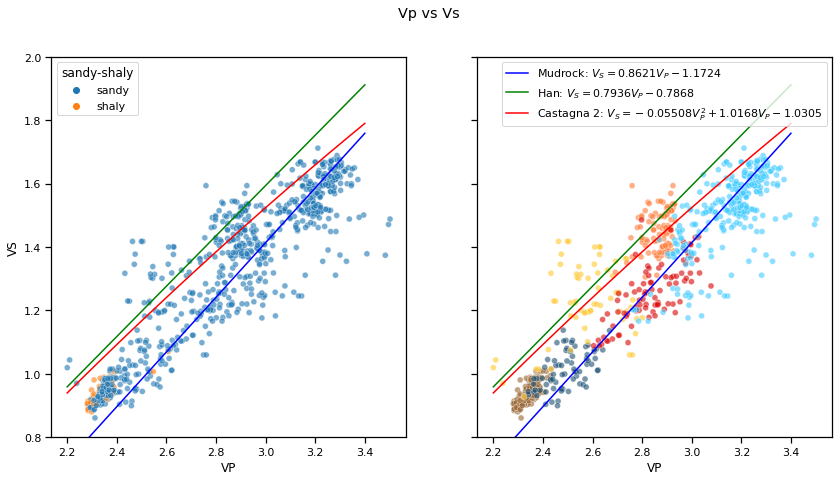

In [23]:
### SANDY - SHALY colours have switched around. sandy-orange, shaly-blue

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14,7))
fig.suptitle('Vp vs Vs')

sns.scatterplot(ax=ax1, data=well2[well2.LABELS!='0'], x="VP", y="VS", hue='sandy-shaly', alpha=0.6)
# ax1.plot(vpx, vs_cast, 'k', label="Castagna: $V_S = 0.8042*V_P - 0.8559$")
ax1.plot(vpx, vs_mudrock, 'b', label="Mudrock")
ax1.plot(vpx, vs_han, 'g', label="Han")
# ax1.plot(vpx, vs_79, 'magenta', label="79")
ax1.plot(vpx, vs_cast2, 'r', label="Castagna 2")

sns.scatterplot(ax=ax2, data=well2[well2.LABELS!='0'], x="VP", y="VS", hue='LABELS', legend=False, palette=ccc[:-1], alpha=0.6)
# ax2.plot(vpx, vs_cast, 'k', label="Castagna: $V_S =0.8042V_P - 0.8559$")
ax2.plot(vpx, vs_mudrock, 'b', label="Mudrock: $V_S = 0.8621V_P - 1.1724$")
ax2.plot(vpx, vs_han, 'g', label="Han: $V_S= 0.7936V_P - 0.7868$")
# ax2.plot(vpx, vs_79, 'magenta', label="79: $V_S = 0.79V_P - 0.79$")
ax2.plot(vpx, vs_cast2, 'r', label="Castagna 2: $V_S = -0.05508V_P^2 + 1.0168V_P - 1.0305$")
plt.ylim(0.8,2.0)

plt.legend()
plt.show();

Model a constant-cement line using modified Hashin-Shtrikman lower bound combined with Dvorkin-Nur cement model to match the trend of the reservoir sands, assuming 100% quartz.

### Q: What is the volume of cement in the reservoir sands?
Answer: 

---

Use modified H-S lower bound to model the cap-rock shales, assuming a critical porosity of 0.6.

### Q: What effective bulk and shear mineral moduli are needed to match the shale data?
Answer: 

### Q: What can these values say about the mineralogical composition of the shales?
Answer: 

---

## 2.
Make crossplots of $V_p$ versus $V_s$. Compare with mudrock line (chapter 1) and dry rock line ($V_p/V_s=1.5$). What do $V_p-V_s$ relationships tell you about lithology and fluids?

## 3.
Make crossplots of AI versus $V_p / V_s$. Superimpose on appropriate rock physics template (RPT). Interpret the trends you see in terms of fluid, porosity, lithology, sorting, cement or other effects. What can you say about seismic contrasts between reservoir sands and cap-rock shales from the RPT analysis?

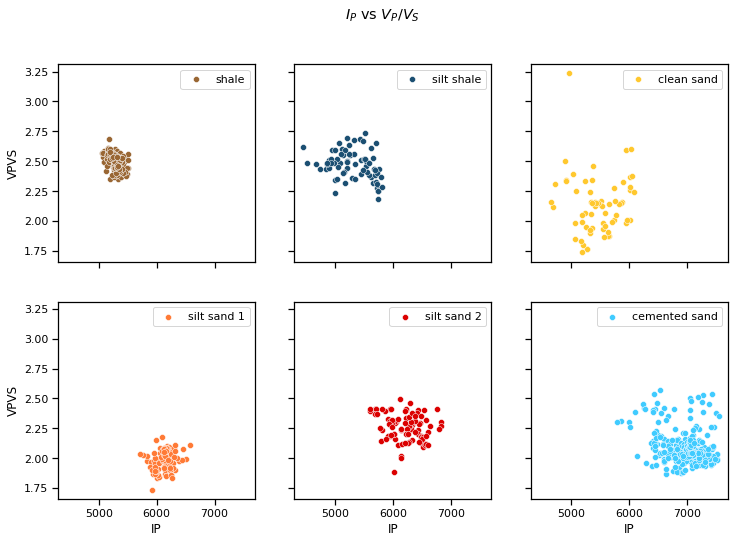

In [24]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,8))
fig.suptitle('$I_P$ vs $V_P/V_S$')
sns.scatterplot(ax=ax1, x=well2[well2.LABELS=='shale']['IP'], y=well2[well2.LABELS=='shale']['VPVS'], color=ccc[0], label="shale")
sns.scatterplot(ax=ax2, x=well2[well2.LABELS=='sltShale']['IP'], y=well2[well2.LABELS=='sltShale']['VPVS'], color=ccc[1], label="silt shale")
sns.scatterplot(ax=ax3, x=well2[well2.LABELS=='clnSand']['IP'], y=well2[well2.LABELS=='clnSand']['VPVS'], color=ccc[2], label="clean sand")
sns.scatterplot(ax=ax4, x=well2[well2.LABELS=='sltSand1']['IP'], y=well2[well2.LABELS=='sltSand1']['VPVS'], color=ccc[3], label="silt sand 1")
sns.scatterplot(ax=ax5, x=well2[well2.LABELS=='sltSand2']['IP'], y=well2[well2.LABELS=='sltSand2']['VPVS'], color=ccc[4], label="silt sand 2")
sns.scatterplot(ax=ax6, x=well2[well2.LABELS=='cemSand']['IP'], y=well2[well2.LABELS=='cemSand']['VPVS'], color=ccc[5], label="cemented sand")

for ax in fig.get_axes():
    ax.label_outer()

In [25]:
# ip_rpt1, vpvs_rpt1 = rpt(model='stiff',vsh=0.6,fluid='oil',phic=0.4,Cn=8,P=45,f=.3)

In [26]:
# ip_rpt0, vpvs_rpt0 = rpt(model='soft',vsh=0.6,fluid='oil',phic=0.5,Cn=12,P=45,f=.3)

Interpret the trends you see in terms of:

* fluid, 
* porosity, 
* lithology, 
* sorting, 
* cement,
* other effects.

What can you say about seismic contrasts between reservoir sands and cap-rock shales from the RPT analysis?

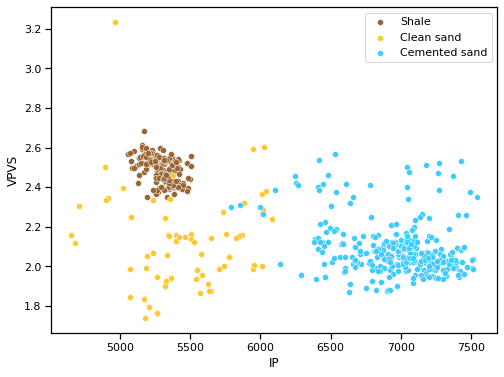

In [27]:
plt.figure(figsize=(8,6))
#plt.plot(ip_rpt0, vpvs_rpt0, 'sk', mew=0, alpha=0.5)
sns.scatterplot(x=well2[well2.LABELS==facies_labels[0]]['IP'], y=well2[well2.LABELS==facies_labels[0]]['VPVS'], color=ccc[0], label="Shale")
#sns.scatterplot(x=well2[well2.LABELS==facies_labels[1]]['IP'], y=well2[well2.LABELS==facies_labels[1]]['VPVS'], color=ccc[1], label="Silt shale")
sns.scatterplot(x=well2[well2.LABELS==facies_labels[2]]['IP'], y=well2[well2.LABELS==facies_labels[2]]['VPVS'], color=ccc[2], label="Clean sand")
#sns.scatterplot(x=well2[well2.LABELS==facies_labels[3]]['IP'], y=well2[well2.LABELS==facies_labels[3]]['VPVS'], color=ccc[3], label="Silt sand1")
#sns.scatterplot(x=well2[well2.LABELS==facies_labels[4]]['IP'], y=well2[well2.LABELS==facies[4]]['VPVS'], color=ccc[4], label="Silt sand2")
sns.scatterplot(x=well2[well2.LABELS==facies_labels[5]]['IP'], y=well2[well2.LABELS==facies_labels[5]]['VPVS'], color=ccc[5], label="Cemented sand")
plt.legend();

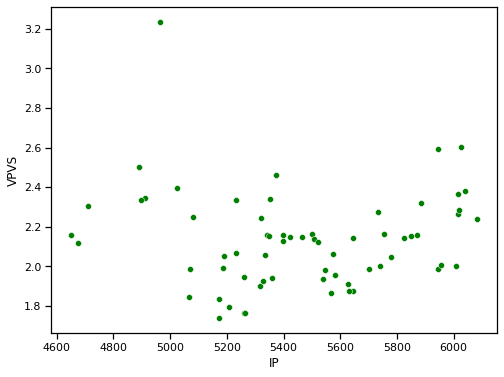

In [28]:
plt.figure(figsize=(8,6))
# plt.plot(ip_rpt1, vpvs_rpt1, 'sk', mew=0, alpha=0.5)
sns.scatterplot(x=well2[well2.FACIES==facies[2]]['IP'], y=well2[well2.FACIES==facies[2]]['VPVS'], color="green");

## 4.
Use Greenberg-Castagna or any other shear-wave prediction tool to predict $V_s$ from $V_p$ for Well 2. Assume 80% quartz, 15% feldspar and 5% clays in the sands, and 80% clays and 20% silt (quartz) in the shales. Compare predicted $V_s$ with measured $V_s$.

see `7.2 Predict Vs from Vp-Den-GR-.ipynb`

## 5.
Use empirical porosity trends from Well 2 together with Hertz-Mindlin model to create $V_p$-depth trends for brine-saturated sands. Assume the same mineralogical compositions as in #4. Water depth is 100 m. To create the depth trend, first fit an exponential porosity versus depth trend to the sand points in Well 2. For each depth compute the effective pressure assuming no overpressure. Finally use the porosity and effective pressure as inputs in the Hertz-Mindlin model to compute the velocity-depth trend. What can you say about the reservoir sands?

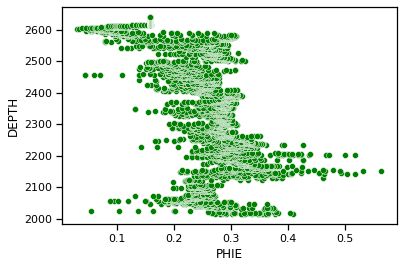

In [29]:
sns.scatterplot(x=well2[well2['sandy-shaly']=='sandy']['PHIE'], y=well2[well2['sandy-shaly']=='sandy']['DEPTH'], color="green");

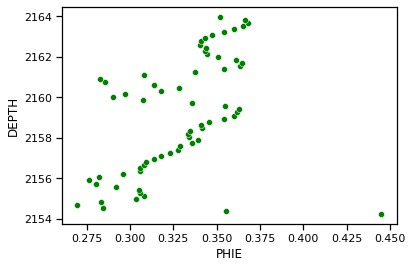

In [30]:
sns.scatterplot(x=well2[well2.LABELS==facies_labels[2]]['PHIE'], y=well2[well2.LABELS==facies_labels[2]]['DEPTH'], color="green");

## Statistical rock physics

## 10. 
Plot histograms, boxplots, cumulative distribution functions and quantile-quantile plots of:

* gamma ray
* Vp
* Vs
* density

Explore the variability in the different rock properties for the different facies

### Histograms

In [31]:
len_dict = dict(well2.groupby('LABELS')['DEPTH'].count())
len_dict

{'0': 3302,
 'cemSand': 303,
 'clnSand': 65,
 'shale': 178,
 'sltSand1': 105,
 'sltSand2': 92,
 'sltShale': 72}

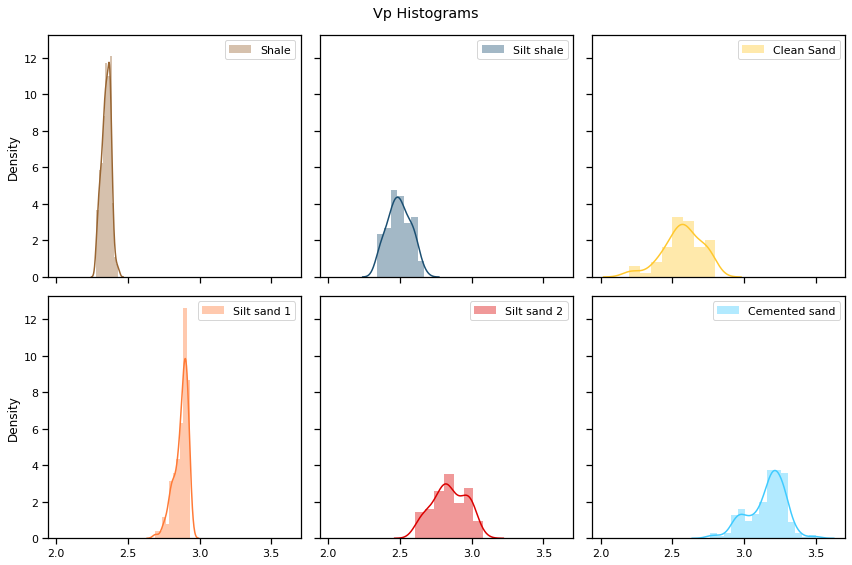

In [32]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,8))
fig.suptitle('Vp Histograms')
sns.distplot(ax=ax1, x=well2[well2.LABELS==facies_labels[0]]['VP'], color=ccc[0], label="Shale")
sns.distplot(ax=ax2, x=well2[well2.LABELS==facies_labels[1]]['VP'], color=ccc[1], label="Silt shale")
sns.distplot(ax=ax3, x=well2[well2.LABELS==facies_labels[2]]['VP'], color=ccc[2], label="Clean Sand")
sns.distplot(ax=ax4, x=well2[well2.LABELS==facies_labels[3]]['VP'], color=ccc[3], label="Silt sand 1")
sns.distplot(ax=ax5, x=well2[well2.LABELS==facies_labels[4]]['VP'], color=ccc[4], label="Silt sand 2")
sns.distplot(ax=ax6, x=well2[well2.LABELS==facies_labels[5]]['VP'], color=ccc[5], label="Cemented sand")
plt.tight_layout()
for ax in fig.get_axes():
    ax.legend()
    ax.label_outer()
    

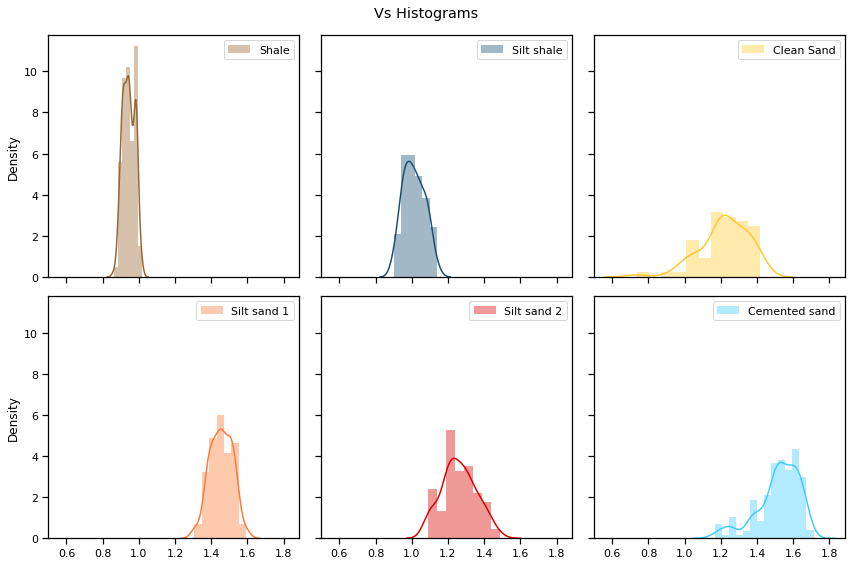

In [33]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,8))
fig.suptitle('Vs Histograms')
sns.distplot(ax=ax1, x=well2[well2.LABELS==facies_labels[0]]['VS'], color=ccc[0], label="Shale")
sns.distplot(ax=ax2, x=well2[well2.LABELS==facies_labels[1]]['VS'], color=ccc[1], label="Silt shale")
sns.distplot(ax=ax3, x=well2[well2.LABELS==facies_labels[2]]['VS'], color=ccc[2], label="Clean Sand")
sns.distplot(ax=ax4, x=well2[well2.LABELS==facies_labels[3]]['VS'], color=ccc[3], label="Silt sand 1")
sns.distplot(ax=ax5, x=well2[well2.LABELS==facies_labels[4]]['VS'], color=ccc[4], label="Silt sand 2")
sns.distplot(ax=ax6, x=well2[well2.LABELS==facies_labels[5]]['VS'], color=ccc[5], label="Cemented sand")
plt.tight_layout()
for ax in fig.get_axes():
    ax.legend()
    ax.label_outer()

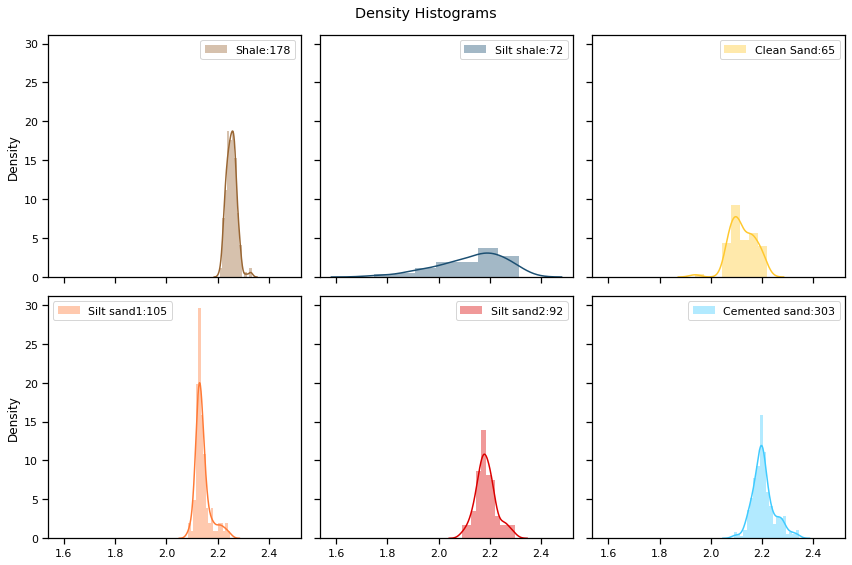

In [34]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,8))
fig.suptitle('Density Histograms')
sns.distplot(ax=ax1, x=well2[well2.LABELS==facies_labels[0]]['DEN'], color=ccc[0], label=f"Shale:{len_dict['shale']}")
sns.distplot(ax=ax2, x=well2[well2.LABELS==facies_labels[1]]['DEN'], color=ccc[1], label=f"Silt shale:{len_dict['sltShale']}")
sns.distplot(ax=ax3, x=well2[well2.LABELS==facies_labels[2]]['DEN'], color=ccc[2], label=f"Clean Sand:{len_dict['clnSand']}")
sns.distplot(ax=ax4, x=well2[well2.LABELS==facies_labels[3]]['DEN'], color=ccc[3], label=f"Silt sand1:{len_dict['sltSand1']}")
sns.distplot(ax=ax5, x=well2[well2.LABELS==facies_labels[4]]['DEN'], color=ccc[4], label=f"Silt sand2:{len_dict['sltSand2']}")
sns.distplot(ax=ax6, x=well2[well2.LABELS==facies_labels[5]]['DEN'], color=ccc[5], label=f"Cemented sand:{len_dict['cemSand']}")
plt.tight_layout()
for ax in fig.get_axes():
    ax.legend()
    ax.label_outer()

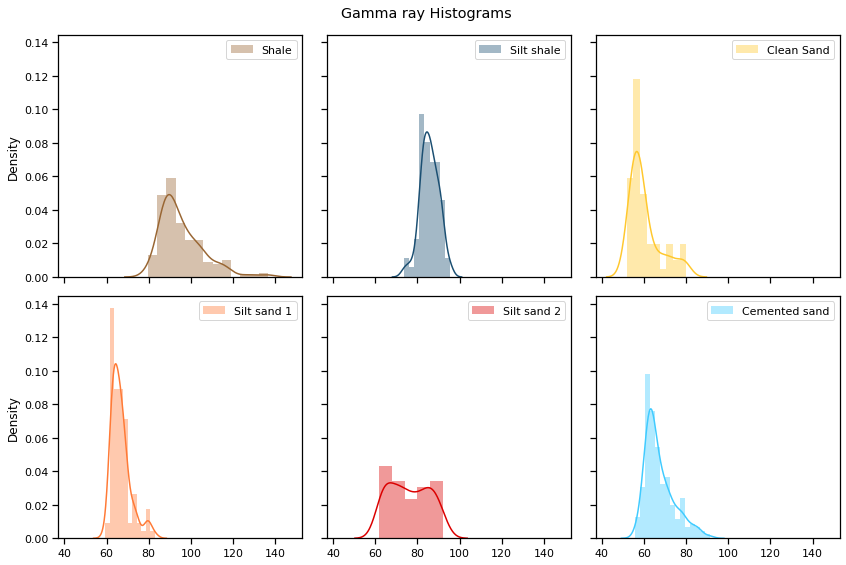

In [35]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,8))
fig.suptitle('Gamma ray Histograms')
sns.distplot(ax=ax1, x=well2[well2.LABELS==facies_labels[0]]['GR'], color=ccc[0], label="Shale")
sns.distplot(ax=ax2, x=well2[well2.LABELS==facies_labels[1]]['GR'], color=ccc[1], label="Silt shale")
sns.distplot(ax=ax3, x=well2[well2.LABELS==facies_labels[2]]['GR'], color=ccc[2], label="Clean Sand")
sns.distplot(ax=ax4, x=well2[well2.LABELS==facies_labels[3]]['GR'], color=ccc[3], label="Silt sand 1")
sns.distplot(ax=ax5, x=well2[well2.LABELS==facies_labels[4]]['GR'], color=ccc[4], label="Silt sand 2")
sns.distplot(ax=ax6, x=well2[well2.LABELS==facies_labels[5]]['GR'], color=ccc[5], label="Cemented sand")
plt.tight_layout()
for ax in fig.get_axes():
    ax.legend()
    ax.label_outer()

### Boxplots

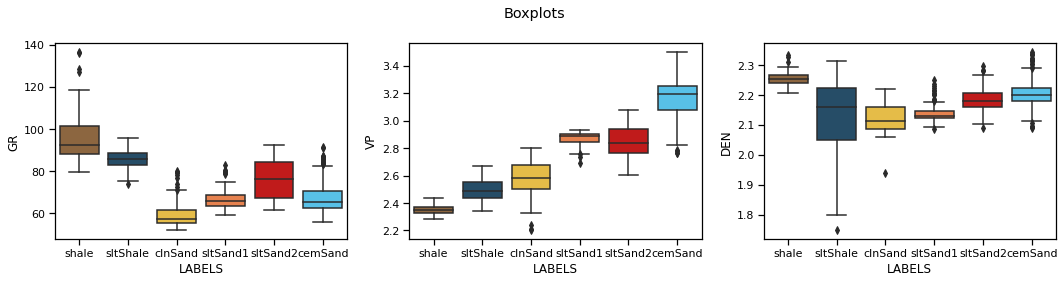

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle('Boxplots')
sns.boxplot(ax=ax1, x="LABELS", y='GR', data=well2[well2.LABELS!='0'], palette=ccc)
sns.boxplot(ax=ax2, x="LABELS", y='VP', data=well2[well2.LABELS!='0'], palette=ccc)
sns.boxplot(ax=ax3, x="LABELS", y='DEN', data=well2[well2.LABELS!='0'], palette=ccc)
#sns.boxplot(ax=ax4, x="LABELS", y='VS', data=well2[well2.LABELS!='0'], palette=ccc)
plt.tight_layout()

### Cumulative distribution functions

### Quantile-Quantile plots

In [37]:
from scipy.stats import shapiro

In [38]:
data_list = [
well2[well2.LABELS=='clnSand']['VP'],
well2[well2.LABELS=='clnSand']['VS'],
well2[well2.LABELS=='clnSand']['GR'],
well2[well2.LABELS=='clnSand']['DEN'],

well2[well2.LABELS=='cemSand']['VP'],
well2[well2.LABELS=='cemSand']['VS'],
well2[well2.LABELS=='cemSand']['GR'],
well2[well2.LABELS=='cemSand']['DEN'],

well2[well2.LABELS=='sltSand1']['VP'],
well2[well2.LABELS=='sltSand1']['VS'],
well2[well2.LABELS=='sltSand1']['GR'],
well2[well2.LABELS=='sltSand1']['DEN'],

well2[well2.LABELS=='sltSand2']['VP'],
well2[well2.LABELS=='sltSand2']['VS'],
well2[well2.LABELS=='sltSand2']['GR'],
well2[well2.LABELS=='sltSand2']['DEN'],

well2[well2.LABELS=='shale']['VP'],
well2[well2.LABELS=='shale']['VS'],
well2[well2.LABELS=='shale']['GR'],
well2[well2.LABELS=='shale']['DEN'],
    
well2[well2.LABELS=='sltShale']['VP'],
well2[well2.LABELS=='sltShale']['VS'],
well2[well2.LABELS=='sltShale']['GR'],
well2[well2.LABELS=='sltShale']['DEN'],
]

for i in range(len(data_list)):
    #print(data_list[i])
    stat, p = shapiro(data_list[i])
    print(f"stat={stat:.3f}, p={p:.3f}")
    if p > 0.05:
        print("Gaussian\n")
    else: print("not Gaussian\n")

stat=0.961, p=0.041
not Gaussian

stat=0.941, p=0.004
not Gaussian

stat=0.817, p=0.000
not Gaussian

stat=0.941, p=0.004
not Gaussian

stat=0.956, p=0.000
not Gaussian

stat=0.917, p=0.000
not Gaussian

stat=0.904, p=0.000
not Gaussian

stat=0.960, p=0.000
not Gaussian

stat=0.896, p=0.000
not Gaussian

stat=0.985, p=0.269
Gaussian

stat=0.868, p=0.000
not Gaussian

stat=0.824, p=0.000
not Gaussian

stat=0.972, p=0.044
not Gaussian

stat=0.982, p=0.220
Gaussian

stat=0.934, p=0.000
not Gaussian

stat=0.977, p=0.109
Gaussian

stat=0.983, p=0.032
not Gaussian

stat=0.969, p=0.001
not Gaussian

stat=0.893, p=0.000
not Gaussian

stat=0.974, p=0.002
not Gaussian

stat=0.983, p=0.422
Gaussian

stat=0.976, p=0.196
Gaussian

stat=0.987, p=0.679
Gaussian

stat=0.948, p=0.005
not Gaussian



In [39]:
import statsmodels.api as sm
import pylab as py

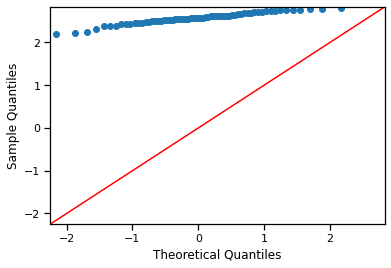

In [40]:
sm.qqplot(well2[well2.LABELS=='clnSand']['VP'], line ='45')
py.show()

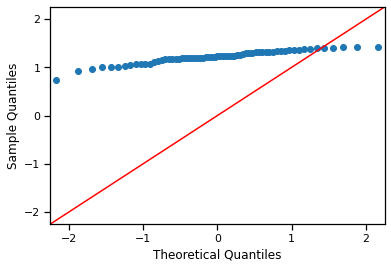

In [41]:
sm.qqplot(well2[well2.LABELS=='clnSand']['VS'], line ='45')
py.show()

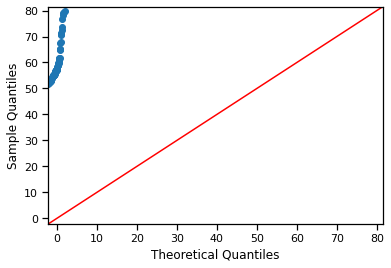

In [42]:
sm.qqplot(well2[well2.LABELS=='clnSand']['GR'], line ='45')
py.show()

### 11.
Estimate and compare univariate pdfs of P-wave impedance for the different facies.

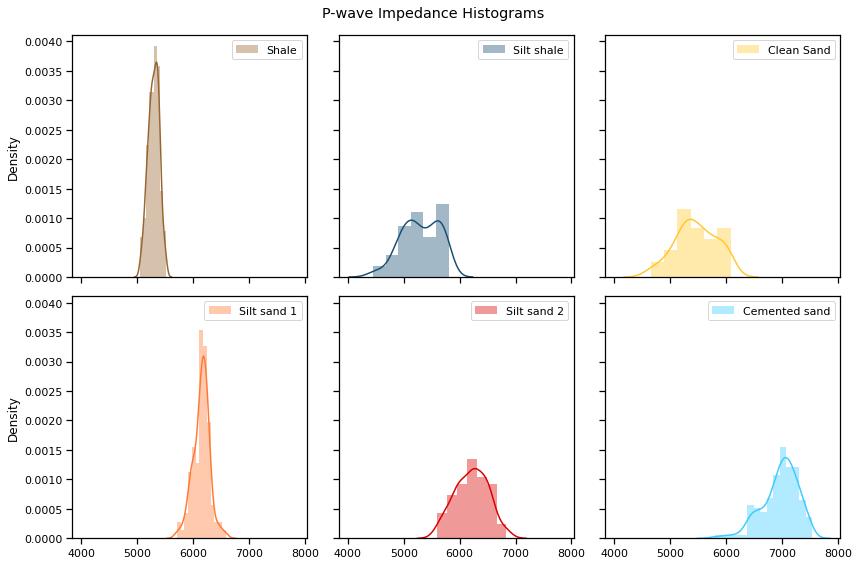

In [43]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,8))
fig.suptitle('P-wave Impedance Histograms')
sns.distplot(ax=ax1, x=well2[well2.LABELS==facies_labels[0]]['IP'], color=ccc[0], label="Shale")
sns.distplot(ax=ax2, x=well2[well2.LABELS==facies_labels[1]]['IP'], color=ccc[1], label="Silt shale")
sns.distplot(ax=ax3, x=well2[well2.LABELS==facies_labels[2]]['IP'], color=ccc[2], label="Clean Sand")
sns.distplot(ax=ax4, x=well2[well2.LABELS==facies_labels[3]]['IP'], color=ccc[3], label="Silt sand 1")
sns.distplot(ax=ax5, x=well2[well2.LABELS==facies_labels[4]]['IP'], color=ccc[4], label="Silt sand 2")
sns.distplot(ax=ax6, x=well2[well2.LABELS==facies_labels[5]]['IP'], color=ccc[5], label="Cemented sand")
plt.tight_layout()
for ax in fig.get_axes():
    ax.legend()
    ax.label_outer()

## 12.
Make a color-coded crossplot of gamma ray versus P-wave Impedance for the different facies. Explore qualitatively whether the clean sands (low gamma ray) can be separated from the shales (high gamma ray) using P-wave impedance.

The clean sands (`clnSand`) cannot be separated from shales using P-wave impedance alone.

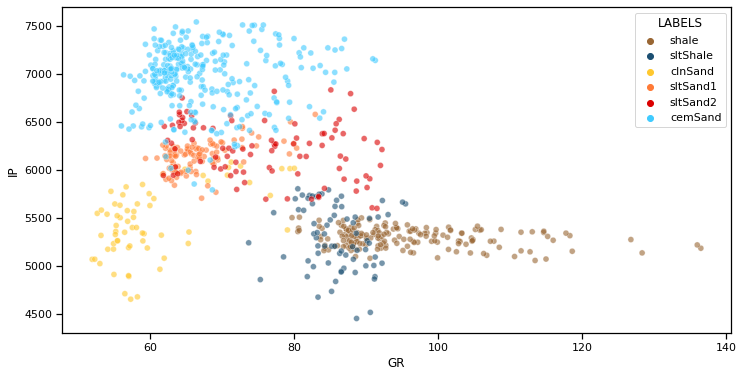

In [44]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=well2[well2.LABELS!='0'], x="GR", y="IP", hue='LABELS', palette=ccc[:-1], alpha=0.6);

## 13
Estimate 2D pdfs for P- and S-wave impedance for the clean sand, cemented sand and shale facies.

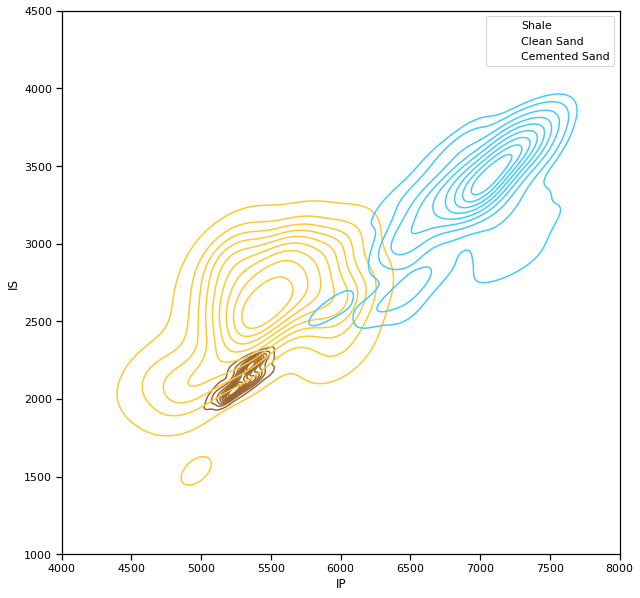

In [45]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.kdeplot(data=well2[well2.LABELS=='shale'], x='IP', y='IS', color=ccc[0], label="Shale")
sns.kdeplot(data=well2[well2.LABELS=='clnSand'], x='IP', y='IS', color=ccc[2], label="Clean Sand")
sns.kdeplot(data=well2[well2.LABELS=='cemSand'], x='IP', y='IS', color=ccc[5], label="Cemented Sand")
plt.xlim(4000,8000); plt.ylim(1000,4500)
plt.legend();

## 14
Monte Carlo simulation: compute the noparametric univariate cdf of Vp for the clean sand facies.  

## 15
Derive the distributons of P-wave velocity and impedance for oil-saturated clean sand.  For this problem, the Well 2 data for clean sands `clnSands`, represent brine-saturated sands.  Draw 1000 correlated MC realisations of Vp, Vs and density from the log data.  Propagate the simulated points through Gassmann's relation to get 1000 realisations of Vp, Vs and density for oil-saturated clean sands.  Use the same fluid properties as in Problem (7). Compare the histograms and pdfs of P-wave velocity and impedance for the original brine-saturated clean sand, and the derived oil-saturated sands. Using simulations we can derive the pdfs and extend our training data beyond the conditions encountered in the well.

In [46]:
# create frm logs
#logs = df[df.RESERVOIR == 1]
sand = (well2.LABELS == 'clnSand')
# shale = (well2.RESERVOIR == 0)

vpg, vsg, rhog, kg = frm(well2.VP, well2.VS, well2.DEN, RHO_BRINE, K_BRINE, RHO_OIL, K_OIL, well2.K0, well2.PHIE)

well2['VP_FRMO'] = well2.VP
well2['VS_FRMO'] = well2.VS
well2['RHO_FRMO'] = well2.DEN

well2['VP_FRMO'][sand] = vpg[sand]
well2['VS_FRMO'][sand] = vsg[sand]
well2['RHO_FRMO'][sand] = rhog[sand]

well2['IP_FRMO'] = well2.VP_FRMO*well2.RHO_FRMO
well2['IS_FRMO'] = well2.VS_FRMO*well2.RHO_FRMO
well2['VPVS_FRMO'] = well2.VP_FRMO/well2.VS_FRMO

In [47]:
# well2[well2.LABELS=='clnSand'][['VP', 'VS', 'IP', 'IP_FRMO', 'VPVS', 'VPVS_FRMO', 'LABELS']].head(20)

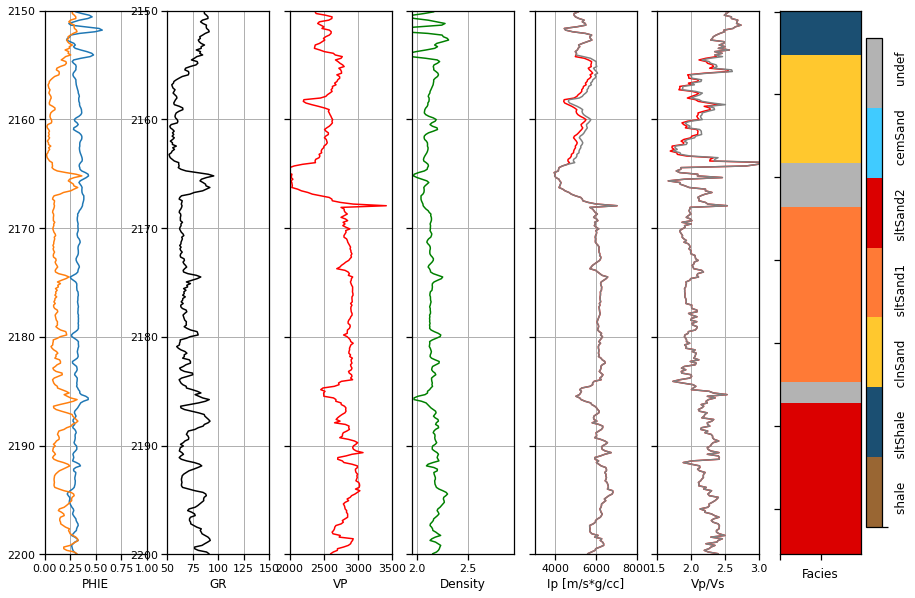

In [48]:
#ztop=well2.DEPTH.min(); zbot=well2.DEPTH.max()
ztop=2150; zbot=2200
ll=well2[(well2.DEPTH>=ztop) & (well2.DEPTH<=zbot)]

cluster=np.repeat(np.expand_dims(ll['FCODES'].values,1), 100, 1)

f, ax = plt.subplots(nrows=1, ncols=7, figsize=(15, 10))

ax[0].plot(ll.PHIE,    ll.DEPTH, label='PHIE')
ax[0].plot(ll.VSH,     ll.DEPTH, label='VSH')
ax[1].plot(ll.GR,      ll.DEPTH, '-k', label='GR')
ax[2].plot(ll.VP*1000, ll.DEPTH, '-r', label='VP')
ax[3].plot(ll.DEN,     ll.DEPTH, '-g', label='Density')
ax[4].plot(ll.IP_FRMO*1000, ll.DEPTH, '-r')
ax[4].plot(ll.IP,      ll.DEPTH, '-', color='0.5')
ax[5].plot(ll.VPVS_FRMO, ll.DEPTH, '-r')
ax[5].plot(ll.VPVS,    ll.DEPTH, '-', color='0.5')

im=ax[6].imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=len(ax)-1)#4)

cbar=plt.colorbar(im, ax=ax[6], aspect=32)
#cbar.set_label('0=undef,1=shale,2=sltShale,3=clnSand,4=sltSand1,5=sltSand2,6=cemSand')
# cbar.set_ticks(range(0,4+1)); cbar.set_ticklabels(range(0,4+1))
cbar.set_label((6*' ').join(['shale', 'sltShale', 'clnSand', 'sltSand1', 'sltSand2', 'cemSand', 'undef']))

cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

for i in range(len(ax)-1):
    ax[i].set_ylim(ztop,zbot)
    ax[i].invert_yaxis()
    ax[i].grid()
    ax[i].locator_params(axis='x', nbins=4)
#ax[0].legend(fontsize='small', loc='lower right')

ax[0].set_xlabel("PHIE"),          ax[0].set_xlim(0,1)
ax[1].set_xlabel("GR"),            ax[1].set_xlim(50, 150),     #ax[1].set_yticklabels([])
ax[2].set_xlabel("VP"),            ax[2].set_xlim(2000, 3500), ax[2].set_yticklabels([])
ax[3].set_xlabel("Density"),       ax[3].set_xlim(1.95, 2.95), ax[3].set_yticklabels([])
ax[4].set_xlabel("Ip [m/s*g/cc]"), ax[4].set_xlim(3000,8000), ax[4].set_yticklabels([])
ax[5].set_xlabel("Vp/Vs"),         ax[5].set_xlim(1.5,3.0),    ax[5].set_yticklabels([])
ax[6].set_xlabel('Facies'),        ax[6].set_yticklabels([]),  ax[6].set_xticklabels([]);

## 16
Classify Well 3 into different facies based on the training data from Well 2. Use a minimum Mahalanobis distance discriminant classification. Gamma ray and Vp will be the input attributes for the classification.  Test the classification error rate in the training data and then classify Well 3.  Compare the classification with one attribute (gamma ray alone) and with tow attributes (gamma ray and Vp).  Remember to normalise the gamma ray values in Well 3 to be within the range observed in the type-well 2.  A color-coded cross-plot of gamma ray versus Vp will help in understanding ualitatively some of the causes for misclassification.

In [49]:
# see Well_Facies_Classification.ipybn

# see Well_Facies_Classification.ipynb
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy.stats as ss

scaler = StandardScaler()
GR2 = np.array(well2.GR).reshape(-1, 1)
GR3 = np.array(well3.GR).reshape(-1, 1)
X2 = scaler.fit_transform(GR2)
X3 = scaler.fit_transform(GR3)
x3 = ss.zscore(X3) * well2.GR.std() + well2.GR.mean()
x3.mean(), x3.std()

well2['GR_norm'] = X2
well3['GR_norm'] = X3
well3['GR_normW2'] = x3

train = well2[['VP', 'GR', 'FACIES']][well2['FACIES']!=0]
test = well3[['VP',  'GR_normW2']]
y = train.FACIES
X = train[['VP', 'GR']]

# create X_train, X_test from un-standarised X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
# Standardise X_train
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
# Standardise X_test from X_train
X_test = scaler.transform(X_test)

model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
yprob = model.predict_proba(X_test)

X_well3 = np.array(well3[['VP', 'GR_normW2']])
X_well3 = scaler.transform(X_well3)
y_pred_well3 = model.predict(X_well3)

well3['FACIES_p'] = y_pred_well3

## 17
Estimate 2D pdfs of gamma ray and Vp from the training data in Well 2 for the different facies.  Use the pdfs in Bayes classification of Well 3.  Compare with the classification obtained by discriminatnt analysis in Problem (16).

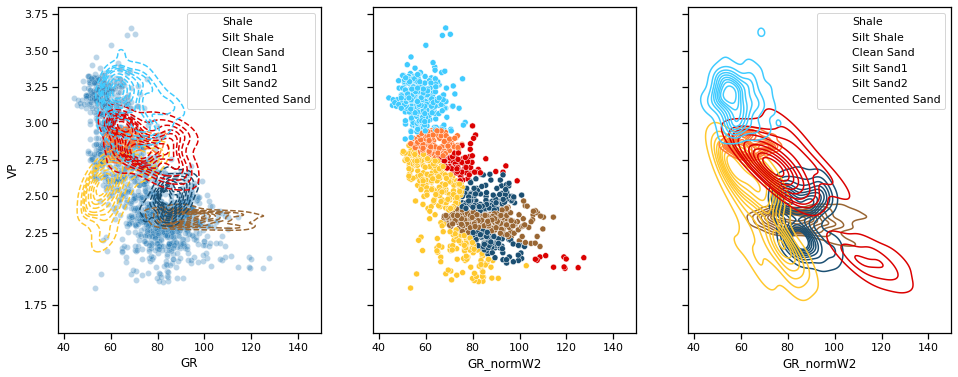

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,6), sharex=True, sharey=True)
sns.kdeplot(ax=ax1, data=well2[well2.LABELS=='shale'], x='GR', y='VP', color=ccc[0], label="Shale", linestyles="--")
sns.kdeplot(ax=ax1, data=well2[well2.LABELS=='sltShale'], x='GR', y='VP', color=ccc[1], label="Silt Shale", linestyles="--")
sns.kdeplot(ax=ax1, data=well2[well2.LABELS=='clnSand'], x='GR', y='VP', color=ccc[2], label="Clean Sand", linestyles="--")
sns.kdeplot(ax=ax1, data=well2[well2.LABELS=='sltSand1'], x='GR', y='VP', color=ccc[3], label="Silt Sand1", linestyles="--")
sns.kdeplot(ax=ax1, data=well2[well2.LABELS=='sltSand2'], x='GR', y='VP', color=ccc[4], label="Silt Sand2", linestyles="--")
sns.kdeplot(ax=ax1, data=well2[well2.LABELS=='cemSand'], x='GR', y='VP', color=ccc[5], label="Cemented Sand", linestyles="--")
sns.scatterplot(ax=ax1, data=well3, x="GR_normW2", y="VP", alpha=0.3)
ax1.legend()

sns.scatterplot(ax=ax2, data=well3, x="GR_normW2", y="VP", hue="FACIES_p", legend=False, palette=ccc[:-1])

sns.kdeplot(ax=ax3, data=well3[well3.FACIES_p==1], x='GR_normW2', y='VP', color=ccc[0], label="Shale")
sns.kdeplot(ax=ax3, data=well3[well3.FACIES_p==2], x='GR_normW2', y='VP', color=ccc[1], label="Silt Shale")
sns.kdeplot(ax=ax3, data=well3[well3.FACIES_p==3], x='GR_normW2', y='VP', color=ccc[2], label="Clean Sand")
sns.kdeplot(ax=ax3, data=well3[well3.FACIES_p==4], x='GR_normW2', y='VP', color=ccc[3], label="Silt Sand1")
sns.kdeplot(ax=ax3, data=well3[well3.FACIES_p==5], x='GR_normW2', y='VP', color=ccc[4], label="Silt Sand2")
sns.kdeplot(ax=ax3, data=well3[well3.FACIES_p==6], x='GR_normW2', y='VP', color=ccc[5], label="Cemented Sand")
ax3.legend();

## 18
Using the training data from Well 2 train a feed-forward back-propagation neural network to classify the different facies.  The neural network will have two inputs: gamma ray and Vp.

## 19
Compute the 2D pdfs of AVO intercept, R(0), and gradient, G, for the following pairs of cap-rock over reservoir rock: 
* shale/clean sand `shale`/`clnSand`(brine)
* shale/clean sand (oil)
* shale/cemented sand (brine)
* shale/cemented sand (oil)
* shale/silty sand1 (brine)
* shale/silty sand1 (oil)
* shale/silty shale
* shale/shale

**The data for the six different facies in Well 2 represent brine-saturated conditions.** Derived distributions for oil-sturated conditions will have to be obtained using Monte Carlo simulation. For each cap-rock/reservoir-rock pair, draw 1000 correlated MC points of (Vp, Vs, rho) for the cap-rock as well as the reservoir rock.  Propagate the smiulated point throgh the equations for R(0) and G to obtain 1000 simulated R(0)-G pairs.  Estimate the pdfs from the simulated point for each class.

### see '2D-nonparametric-sampling.ipynb'

## 20
From the simulations of R(0) and G, compute the classification error rate and confusion matrix using a leave-one-out jackknife (Chapter 3). Use any classification method. Combine all the oil sands into one group, the brine sands into a second group and the silty-shales and shales into a third group. Now compute the classification error rate and confusion matrix for the three groups instead of the original six groups.  Do a bootstrap analysis of the uncertainty of the error rate by drawing a large number of bootstrap samples of the training data and computing classification error rates for all of the bootstrap samples.

## 21
Compute classification error rate and confusion matrix for different pairs of attributes for the different facies classes: oil sands brine sands and shales (including silty shales).  Oil-sand distributiions will have to be derived using MC simulations and fluid substitution.  Compute the following different attribute sets: P-impedance and S-impedance; AI-EI(30); lambda-mu, P-impedance, S-impedance, and density.  For each attribute set estimate and compare the classification confusion matrix for different classification methods.